In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
# Import necessary libraries
from src.models import RENR
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [21]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
    
nExp = yExp.size



In [22]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Set input number
input_size = 5
inputnumberD = input_size-1

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [23]:
#Set dimensions for RNN layers
n = dExp[0, 0].shape[1] # input dimensions--nb of col
p = yExp[0, 0].shape[1] # output dimensions
n_xi = 20 #linear matrix dimension
l = 20 # in the paper q, dimension of the square matrix D11 -- number of non-linear layers of the RE

REN = RENR(n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 20
LOSS = np.zeros(epochs)


In [24]:
#graduating learning rate
t_end = t_end - 1
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    
    #loop over the experiments
    for exp in range(nExp - 1):
        #get output
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze() #??
        yRENm = torch.randn(p, t_end + 1, device=device, dtype=dtype) #same if torch.zeros ?
        y = y.T
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        #get input
        d = torch.from_numpy(dExp[0, exp]).float().to(device).T #????????
        for t in range(1, t_end):
            u = torch.tensor(d[:, t])  #[inputnumberD, t]])
            yRENm[:, t], xi = REN(t, u, xi)         # prend la nonlin du precedent step pour calculer le REN suivant
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
    #torch.save(REN.state_dict(), filename)
        
    # Calculate loss mean and backpropagate
    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    REN.set_model_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"Gamma1: {REN.sg ** 2}")
    LOSS[epoch] = loss


C:\Users\adela\AppData\Local\Temp\ipykernel_15372\3651567057.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(d[:, t])  #[inputnumberD, t]])


Epoch: 1 	||	 Loss: 0.32658645510673523
Gamma1: tensor([[6.5143e-05]], grad_fn=<PowBackward0>)
Epoch: 2 	||	 Loss: 0.3249824345111847
Gamma1: tensor([[0.0058]], grad_fn=<PowBackward0>)
Epoch: 3 	||	 Loss: 0.3244158923625946
Gamma1: tensor([[0.0228]], grad_fn=<PowBackward0>)
Epoch: 4 	||	 Loss: 0.3188231885433197
Gamma1: tensor([[0.0531]], grad_fn=<PowBackward0>)
Epoch: 5 	||	 Loss: 0.30401840806007385
Gamma1: tensor([[0.0970]], grad_fn=<PowBackward0>)
Epoch: 6 	||	 Loss: 0.27945566177368164
Gamma1: tensor([[0.1564]], grad_fn=<PowBackward0>)
Epoch: 7 	||	 Loss: 0.24395175278186798
Gamma1: tensor([[0.2326]], grad_fn=<PowBackward0>)
Epoch: 8 	||	 Loss: 0.19606979191303253
Gamma1: tensor([[0.3271]], grad_fn=<PowBackward0>)
Epoch: 9 	||	 Loss: 0.14271388947963715
Gamma1: tensor([[0.4422]], grad_fn=<PowBackward0>)
Epoch: 10 	||	 Loss: 0.08951789140701294
Gamma1: tensor([[0.5793]], grad_fn=<PowBackward0>)
Epoch: 11 	||	 Loss: 0.043761610984802246
Gamma1: tensor([[0.5946]], grad_fn=<PowBackwar

In [26]:

torch.save(REN.state_dict(), pjoin(folderpath, 'parameters.pth'))
REN.load_state_dict(torch.load(pjoin(folderpath, 'parameters.pth')))

In [27]:
##############################################



yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.T
yval = yval.squeeze()

yRENm_val = torch.zeros(p, t_end + 1, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device).T
loss_val = 0
for t in range(1, t_end):
    u = torch.tensor(dval[:, t])#[inputnumberD, t])
    yRENm_val[:, t], xiVal = REN(t, u, xiVal)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])
 ##############################################


C:\Users\adela\AppData\Local\Temp\ipykernel_15372\4219053609.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(dval[:, t])#[inputnumberD, t])


In [ ]:
###############""# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

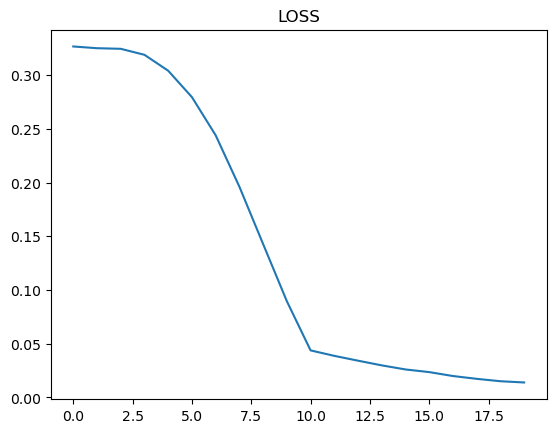

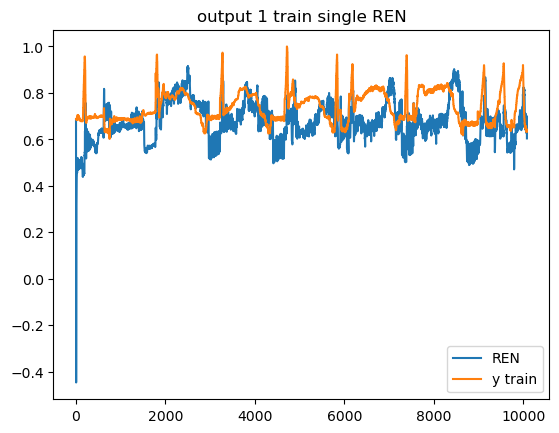

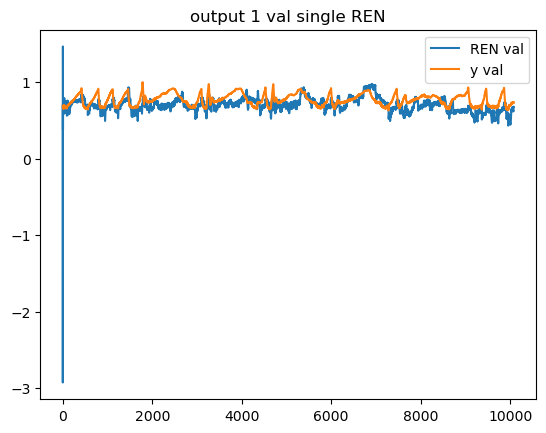

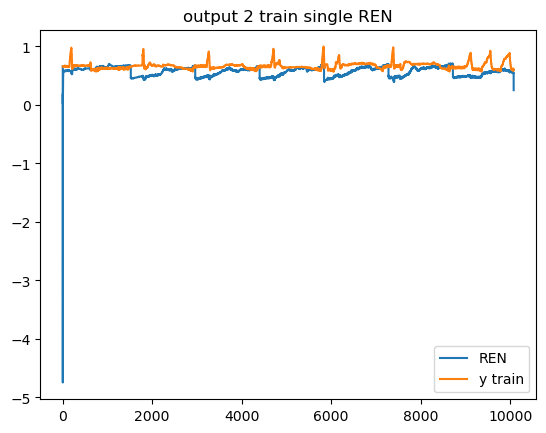

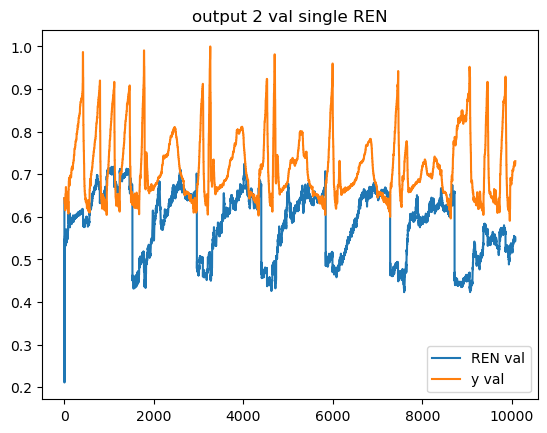

IndexError: index 2 is out of bounds for dimension 0 with size 2

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

plt.figure('9')
plt.plot(yRENm[0, :].detach().numpy(), label='REN')
plt.plot(y[0, :].detach().numpy(), label='y train')
plt.title("output 1 train single REN")
plt.legend()
plt.show()

plt.figure('10')
plt.plot(yRENm_val[0, 0:t_end].detach().numpy(), label='REN val')
plt.plot(yval[0, 0:t_end].detach().numpy(), label='y val')
plt.title("output 1 val single REN")
plt.legend()
plt.show()

plt.figure('11')
plt.plot(yRENm[1, :].detach().numpy(), label='REN')
plt.plot(y[1, :].detach().numpy(), label='y train')
plt.title("output 2 train single REN")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(yRENm_val[1, 0:t_end].detach().numpy(), label='REN val')
plt.plot(yval[1, 0:t_end].detach().numpy(), label='y val')
plt.title("output 2 val single REN")
plt.legend()
plt.show()

plt.figure('13')
plt.plot(yRENm[2, :].detach().numpy(), label='REN')
plt.plot(y[2, :].detach().numpy(), label='y train')
plt.title("output 3 train single REN")
plt.legend()
plt.show()

plt.figure('14')
plt.plot(yRENm_val[2, 0:t_end].detach().numpy(), label='REN val')
plt.plot(yval[2, 0:t_end].detach().numpy(), label='y val')
plt.title("output 3 val single REN")
plt.legend()
plt.show()


plt.figure('15')
plt.plot(d[inputnumberD, :].detach().numpy(), label='input train')
plt.plot(dval[inputnumberD, :].detach().numpy(), label='input val')
plt.title("input single REN")
plt.legend()
plt.show()

pytorch_total_params_single = sum(p.numel() for p in REN.parameters() if p.requires_grad)

print(f"param single REN: {pytorch_total_params_single}")

print(f"Loss Validation single REN: {loss_val}")